In [ ]:
#!pip install torcheval

In [1]:
import time
import os
import pickle
from pathlib import Path
import json
from typing import List, Optional
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm as notebook_tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import optuna
from optuna.visualization.matplotlib import (plot_param_importances, plot_contour, plot_optimization_history,
                                            plot_slice, plot_parallel_coordinate, plot_rank)
from optuna.integration import PyTorchLightningPruningCallback
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler

import torch
from torch import nn
import torch.nn.functional as F
from torcheval.metrics.functional import binary_f1_score
#from torchmetrics.functional import auc
from torchmetrics import AUROC
import lightning.pytorch as pl

#from transformers import AutoModel, AutoTokenizer

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/edwardyao/anaconda3/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <06D2C3BD-26E5-3AB9-A866-63839BE393A7> /Users/edwardyao/anaconda3/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <7856C0E5-3D52-39C7-8515-71217150BD2E> /Users/edwardyao/anaconda3/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


In [3]:
bs = 2
seq_len = 4
embed_dim = 3

hid_dim = 6

#l_layer = nn.Linear(embed_dim, hid_dim)
l_layer = nn.Parameter(torch.Tensor(hid_dim, embed_dim))
bias = Parameter(torch.Tensor(hid_dim))
rand_tens = torch.randn((bs, seq_len, embed_dim))

l_layer(rand_tens).shape

torch.Size([2, 4, 6])

#### Helper Functions

In [2]:
def save_study_charts(study: optuna.study,
                      study_name: str,
                      dir: str) -> None:

    # save charts of trials
    fig = plt.figure(figsize=(8,8))
    plot_optimization_history(study)
    plt.savefig(f"{dir}/{study_name}_opt_hist.png")

    plt.clf()
    fig = plt.figure(figsize=(12,12))
    plot_parallel_coordinate(study)
    plt.savefig(f"{dir}/{study_name}_parallel_coord.png")

    plt.clf()
    fig = plt.figure(figsize=(12,12))
    plot_param_importances(study)
    plt.savefig(f"{dir}/{study_name}_param_importances.png")

    plt.clf()
    fig = plt.figure(figsize=(12,12))
    plot_rank(study)
    plt.savefig(f"{dir}/{study_name}_rank.png")

    plt.clf()
    fig = plt.figure()
    plot_slice(study)
    plt.savefig(f"{dir}/{study_name}_slice.png")

In [3]:
def split_data(text_df, 
               labels_df,
               #features,
               test_perc=0.15, 
               val_perc=0.15, 
               test_seed=42, 
               val_seed=74) -> tuple[pd.DataFrame]:
    
    val_size = int(len(text_df) * val_perc)
    X_tr, X_te, y_tr, y_te = train_test_split(text_df, labels_df, test_size=test_perc, shuffle=True, 
                                             random_state=test_seed)
    #val_perc = val_size // len(X_tr)
    X_tr, X_val, y_tr, y_val = train_test_split(X_tr, y_tr, test_size=val_size, shuffle=True,
                                               random_state=val_seed)
    
    #y_tr_sub, y_val_sub, y_te_sub = y_tr[features], y_val[features], y_te[features]
    
    return X_tr, X_val, X_te, y_tr, y_val, y_te

#### Directory Paths

In [4]:
DIR = os.getcwd()
TRAIN_FEATURES_PATH = DIR + "/data" + "/train_features_X4juyT6.csv"
TRAIN_LABELS_PATH = DIR + "/data" + "/train_labels_JxtENGl.csv"
MLP_TUNING_DIR = DIR + "/tuning" + "/mlp"

# encoded paths
#DBERTA_CME_PATH = DIR + "/data" + "/cme_deberta_enc.npy"
GTE_CME_PATH = DIR + "/data" + "/cme_gte_enc.npy"
GTE_LE_PATH = DIR + "/data" + "/le_gte_enc.npy"

In [5]:
train_features_df = pd.read_csv(TRAIN_FEATURES_PATH)
train_labels_df = pd.read_csv(TRAIN_LABELS_PATH)

#### Load GTE CME

In [22]:
gte_cme_features = np.load(GTE_CME_PATH)

# add uid to encoded array as df
gte_cme_features_df = pd.DataFrame(gte_cme_features)
gte_cme_features_df["uid"] = train_labels_df["uid"].values

In [23]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(gte_cme_features_df, train_labels_df)

In [24]:
# scaling
gte_cme_scaler = MinMaxScaler()

X_train.drop("uid", axis=1, inplace=True)
X_val.drop("uid", axis=1, inplace=True)
X_test.drop("uid", axis=1, inplace=True)

gte_cme_scaler.fit(X_train)

# leaves as dataframes
gte_cme_train = gte_cme_scaler.transform(X_train.to_numpy())
gte_cme_val = gte_cme_scaler.transform(X_val.to_numpy())
gte_cme_test = gte_cme_scaler.transform(X_test.to_numpy())

#### Load GTE LE

In [6]:
gte_le_features = np.load(GTE_LE_PATH)

# add uid to encoded array as df
gte_le_features_df = pd.DataFrame(gte_le_features)
gte_le_features_df["uid"] = train_labels_df["uid"].values

In [10]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(gte_le_features_df, train_labels_df)

In [11]:
# scaling
gte_le_scaler = MinMaxScaler()

X_train.drop("uid", axis=1, inplace=True)
X_val.drop("uid", axis=1, inplace=True)
X_test.drop("uid", axis=1, inplace=True)

gte_le_scaler.fit(X_train)

# leaves as dataframes
gte_le_train = gte_le_scaler.transform(X_train.to_numpy())
gte_le_val = gte_le_scaler.transform(X_val.to_numpy())
gte_le_test = gte_le_scaler.transform(X_test.to_numpy())

# MLP Single Feature Pred

In [20]:
EPOCHS = 10
SEED = 440
BATCH_SIZE = 16

#DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"
DEVICE = "cpu"

In [13]:
class AbstractionDataset(torch.utils.data.Dataset):
    def __init__(self, 
                 features, 
                 labels, 
                 is_test=False):
        super().__init__()
        
        self.features = features
        self.labels = labels
        self.is_test = is_test

    def __len__(self):
        
        return len(self.features)
    
    def __getitem__(self, idx):
        
        features = self.features[idx]
        labels = self.labels[idx]
        
        return features, labels

class FCN(nn.Module):
    
    def __init__(self, 
                 in_features: int,
                 out_dims: List[int],
                 #task_classes: List[int],
                 #task_type: str,
                 dropout: float):
        super().__init__()
        
        layers = []
        input_size = in_features
        for dim in out_dims:
            layers.append(nn.Linear(input_size, dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            input_size = dim
        
        
        #if task_type == "binary":
        layers.append(nn.Linear(input_size, 1))
        layers.append(nn.Sigmoid())
        
        self.model = nn.Sequential(*layers)
            
#         self.base_model = nn.Sequential(*layers)
#         self.classification_layers = []
#         for task in task_classes:
#             if task > 2: 
#                 self.classification_layers.append(nn.Sequential(nn.Linear(input_size, task),
#                                                           nn.Softmax(dim=1)))
#             else:
#                 self.classification_layers.append(nn.Sequential(nn.Linear(input_size, task),
#                                                           nn.Sigmoid()))
    def forward(self, x: torch.tensor):
        
        return self.model(x)

In [17]:
def objective(trial: optuna.trial, train_features, train_labels, val_features, val_labels):
    
    criterion = nn.BCELoss()
    #auc = AUROC(task="binary")
    
    n_layers = trial.suggest_int("n_layers", 2, 4)
    
    layers = []
    in_features = 1024
    for i in range(n_layers):
        layers.append(trial.suggest_int(f"layer{i}", 128, 512, step=128))
    
    dropout = trial.suggest_float("dropout", 0.1, 0.6, step=0.1)
    lr = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-3, 1e-1, log=True)
    
    model = FCN(in_features=1024, out_dims=layers, dropout=dropout)
    model.to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    train_dataset = AbstractionDataset(features=train_features, labels=train_labels)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
    val_dataset = AbstractionDataset(features=val_features, labels=val_labels)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE)
    
    for ep in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)
            
            optimizer.zero_grad()
            output = model(data)
            
            loss = criterion(output, target.type(torch.float32))
            loss.backward()
            optimizer.step()
            
        model.eval()
        pred_probs = None
        true_answers = None
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(val_loader):
                
                data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)
                output = model(data).reshape((1, -1))
                
                if batch_idx == 0:
                    pred_probs = output
                    true_answers = target.reshape((1, -1))
                else:
                    pred_probs = torch.cat((pred_probs, output), dim=-1)
                    true_answers = torch.cat((true_answers, target.reshape((1, -1))), dim=-1)

#         auc_score = auc(pred_probs.squeeze(0), true_answers.squeeze(0))
#         trial.report(auc_score, ep)
        #preds = torch.round(pred_probs)
        f1 = binary_f1_score(pred_probs.squeeze(0), true_answers.squeeze(0), threshold=0.5)
        trial.report(f1, ep)
        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return f1

#### Running Trial

In [15]:
#feat_names = ['DepressedMood','MentalIllnessTreatmentCurrnt','HistoryMentalIllnessTreatmnt', 'SuicideAttemptHistory','SuicideThoughtHistory']
feat_names = ['SuicideAttemptHistory']

y_train_suiAtt = y_train[feat_names].to_numpy()
y_val_suiAtt = y_val[feat_names].to_numpy()
y_test_suiAtt = y_test[feat_names].to_numpy()

[I 2024-10-12 21:55:03,359] A new study created in Journal with name: mlp_study_gte_cme_suiAttOnly
[I 2024-10-12 21:55:10,469] Trial 0 finished with value: 0.2573099434375763 and parameters: {'n_layers': 2, 'layer0': 512, 'layer1': 512, 'dropout': 0.30000000000000004, 'learning_rate': 0.0007054114335138052, 'weight_decay': 0.01811666125051074}. Best is trial 0 with value: 0.2573099434375763.
[I 2024-10-12 21:55:13,520] Trial 1 finished with value: 0.30337077379226685 and parameters: {'n_layers': 2, 'layer0': 128, 'layer1': 256, 'dropout': 0.2, 'learning_rate': 0.0008018131597301307, 'weight_decay': 0.0037041132792766285}. Best is trial 1 with value: 0.30337077379226685.
[I 2024-10-12 21:55:21,849] Trial 2 finished with value: 0.0 and parameters: {'n_layers': 4, 'layer0': 512, 'layer1': 384, 'layer2': 256, 'layer3': 512, 'dropout': 0.4, 'learning_rate': 0.006181152466966635, 'weight_decay': 0.03488959508491131}. Best is trial 1 with value: 0.30337077379226685.
[I 2024-10-12 21:55:25,039

[I 2024-10-12 21:59:10,939] Trial 64 pruned. 
[I 2024-10-12 21:59:18,531] Trial 65 finished with value: 0.33507850766181946 and parameters: {'n_layers': 3, 'layer0': 384, 'layer1': 512, 'layer2': 256, 'dropout': 0.1, 'learning_rate': 0.00035606644329071993, 'weight_decay': 0.08099034677748294}. Best is trial 51 with value: 0.3681592047214508.
[I 2024-10-12 21:59:24,189] Trial 66 pruned. 
[I 2024-10-12 21:59:26,802] Trial 67 pruned. 
[I 2024-10-12 21:59:35,061] Trial 68 finished with value: 0.37681156396865845 and parameters: {'n_layers': 3, 'layer0': 512, 'layer1': 512, 'layer2': 384, 'dropout': 0.1, 'learning_rate': 0.0004101694514288566, 'weight_decay': 0.06918504443764091}. Best is trial 68 with value: 0.37681156396865845.
[I 2024-10-12 21:59:38,347] Trial 69 pruned. 
[I 2024-10-12 21:59:42,319] Trial 70 pruned. 
[I 2024-10-12 21:59:48,429] Trial 71 pruned. 
[I 2024-10-12 21:59:55,818] Trial 72 pruned. 
[I 2024-10-12 22:00:04,487] Trial 73 finished with value: 0.3510638475418091 and

[I 2024-10-12 22:06:10,450] Trial 172 pruned. 
[I 2024-10-12 22:06:13,397] Trial 173 pruned. 
[I 2024-10-12 22:06:15,615] Trial 174 pruned. 
[I 2024-10-12 22:06:20,850] Trial 175 pruned. 
[I 2024-10-12 22:06:23,321] Trial 176 pruned. 
[I 2024-10-12 22:06:26,726] Trial 177 pruned. 
[I 2024-10-12 22:06:29,101] Trial 178 pruned. 
[I 2024-10-12 22:06:31,816] Trial 179 pruned. 
[I 2024-10-12 22:06:34,348] Trial 180 pruned. 
[I 2024-10-12 22:06:37,837] Trial 181 pruned. 
[I 2024-10-12 22:06:44,511] Trial 182 finished with value: 0.34594595432281494 and parameters: {'n_layers': 3, 'layer0': 512, 'layer1': 128, 'layer2': 256, 'dropout': 0.1, 'learning_rate': 0.00042450781531040097, 'weight_decay': 0.05277742474326117}. Best is trial 68 with value: 0.37681156396865845.
[I 2024-10-12 22:06:46,764] Trial 183 pruned. 
[I 2024-10-12 22:06:49,042] Trial 184 pruned. 
[I 2024-10-12 22:06:55,595] Trial 185 finished with value: 0.34224599599838257 and parameters: {'n_layers': 3, 'layer0': 512, 'layer1':

[I 2024-10-12 22:13:21,453] Trial 309 pruned. 
[I 2024-10-12 22:13:25,646] Trial 310 pruned. 
[I 2024-10-12 22:13:28,147] Trial 311 pruned. 
[I 2024-10-12 22:13:30,902] Trial 312 pruned. 
[I 2024-10-12 22:13:33,137] Trial 313 pruned. 
[I 2024-10-12 22:13:35,761] Trial 314 pruned. 
[I 2024-10-12 22:13:44,012] Trial 315 finished with value: 0.3419688940048218 and parameters: {'n_layers': 3, 'layer0': 512, 'layer1': 512, 'layer2': 256, 'dropout': 0.1, 'learning_rate': 9.143728383065895e-05, 'weight_decay': 0.004535158380344305}. Best is trial 68 with value: 0.37681156396865845.
[I 2024-10-12 22:13:46,936] Trial 316 pruned. 
[I 2024-10-12 22:13:49,507] Trial 317 pruned. 
[I 2024-10-12 22:13:52,429] Trial 318 pruned. 
[I 2024-10-12 22:13:55,252] Trial 319 pruned. 
[I 2024-10-12 22:13:58,081] Trial 320 pruned. 
[I 2024-10-12 22:14:06,537] Trial 321 finished with value: 0.3333333432674408 and parameters: {'n_layers': 3, 'layer0': 512, 'layer1': 512, 'layer2': 256, 'dropout': 0.1, 'learning_ra

Number of finished trials:  400
Best trial:
  Value: 0.37681156396865845
  Params: 
    n_layers: 3
    layer0: 512
    layer1: 512
    layer2: 384
    dropout: 0.1
    learning_rate: 0.0004101694514288566
    weight_decay: 0.06918504443764091


/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_41973/4118054911.py:17: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)
/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_41973/4118054911.py:22: ExperimentalWarning: plot_rank is experimental (supported from v3.2.0). The interface can change in the future.
  plot_rank(study)
[W 2024-10-12 22:18:25,161] Output figures of this Matplotlib-based `plot_rank` function would be different from those of the Plotly-based `plot_rank`.
/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_41973/4118054911.py:27: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  plot_slice(study)


<Figure size 800x800 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

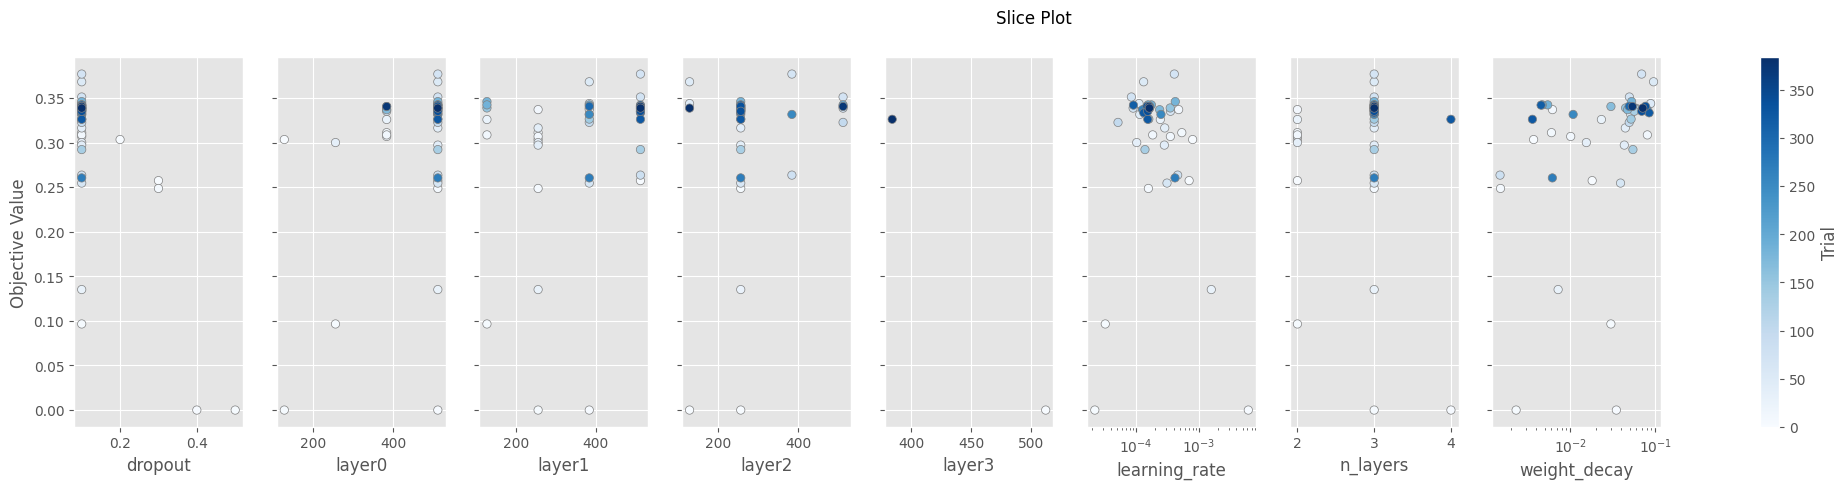

In [25]:
# study identifiers
study_name = "mlp_study_gte_cme_suiAttOnly"
storage_name = optuna.storages.JournalStorage(
    optuna.storages.journal.JournalFileBackend("./optuna_journal_storage_mlp_gte_cme_suiAttOnly.log")
)


# tuning directory for model
if not os.path.exists(MLP_TUNING_DIR):
    os.makedirs(MLP_TUNING_DIR)

# check for a saved sampler
try:
    sampler = pickle.load(open(f"{MLP_TUNING_DIR}/{study_name}_sampler.pkl", "rb"))
except (OSError, IOError) as e:
    sampler = TPESampler(seed=SEED)

pruner = MedianPruner()
    
# create study and optimize
study = optuna.create_study(study_name=study_name, storage=storage_name,
                                sampler=sampler, pruner=pruner, direction="maximize",
                                load_if_exists=True)

study.optimize(lambda trial: objective(trial, 
                                       train_features=gte_cme_train, train_labels=y_train_suiAtt,
                                       val_features=gte_cme_val, val_labels=y_val_suiAtt), 
               n_trials=400, timeout=2000)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


with open(f"{MLP_TUNING_DIR}/{study_name}_sampler.pkl", "wb") as fout:
    pickle.dump(study.sampler, fout)

# saving charts from study
try:
    save_study_charts(study=study, study_name=study_name, dir=MLP_TUNING_DIR)
except Exception as e:
    print(f"Error when trying to save charts: {e}")

### Lightning Implementation

Issue where the kernel keeps dying even when batch size is 1

In [ ]:
class LightningNet(pl.LightningModule):
    
    def __init__(self, 
                 in_features: int,
                 out_dims: List[int],
                 #task_classes: List[int],
                 lr: float,
                 weight_decay: float,
                 dropout: float):
        super().__init__()
        
        self.lr = lr
        self.weight_decay = weight_decay
        self.model = FCN(in_features, out_dims, dropout)
        self.criterion = nn.BCELoss()
        self.auc = AUROC(task="binary")
    
        
    def forward(self, x: torch.tensor):
        
        self.model(x)
    
    def training_step(self, batch, batch_idx: int):
        
        data, targets = batch
        out = self.model(data)
        
        return self.criterion(out, targets)
    
    def validation_step(self, batch, batch_idx: int):
        
        data, targets = batch
        out = self.model(data)
        self.log("val_AUC", self.auc(out, targets), sync_dist=True)
        self.log("Epoch_AUC", self.auc(out, targets), on_step=False, on_epoch=True, sync_dist=True)
    
    def configure_optimizers(self) -> torch.optim.Optimizer:
        
        return torch.optim.AdamW(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)


class AbstractionDataModule(pl.LightningDataModule):
    
    def __init__(self, 
                 train_features,
                 train_labels,
                 val_features,
                 val_labels,
                 test_features,
                 test_labels,
                 batch_size):
        super().__init__()
        
        self.train_features = train_features
        self.val_features = val_features
        self.test_features = test_features
        
        self.train_labels = train_labels
        self.val_labels = val_labels
        self.test_labels = test_labels
        
        self.batch_size = batch_size
        
    def train_dataloader(self) -> torch.utils.data.DataLoader:
        
        train_data = AbstractionDataset(self.train_features, self.train_labels)
        
        return torch.utils.data.DataLoader(train_data, batch_size=self.batch_size)
    
    def val_dataloader(self) -> torch.utils.data.DataLoader:
        
        val_data = AbstractionDataset(self.val_features, self.val_labels)
        
        return torch.utils.data.DataLoader(val_data, batch_size=self.batch_size)
    
    def test_dataloader(self) -> torch.utils.data.DataLoader:
        
        test_data = AbstractionDataset(self.test_features, self.test_labels)
        
        return torch.utils.data.DataLoader(test_data, batch_size=self.batch_size)

In [ ]:
def objective(trial: optuna.trial,
             train_features, 
             train_labels,
             val_features,
             val_labels,
             test_features,
             test_labels):
    
    n_layers = trial.suggest_int("n_layers", 2, 4)
    
    layers = []
    in_features = 1024
    for i in range(n_layers):
        layers.append(trial.suggest_int(f"layer{i}", 128, 512, step=128))
    
    dropout = trial.suggest_float("dropout", 0.1, 0.6, step=0.1)
    lr = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-3, 1e-1, log=True)
    
    model = LightningNet(in_features=1024, out_dims=layers, dropout=dropout, lr=lr, weight_decay=weight_decay)
    data_module = AbstractionDataModule(train_features, train_labels,val_features,
                                        val_labels,test_features,test_labels,batch_size=BATCH_SIZE)
    
    callback = PyTorchLightningPruningCallback(trial, monitor="val_AUC")
    
    trainer = pl.Trainer(
        logger=True,
        log_every_n_steps=40,
        #limit_val_batches=PERCENT_VALID_EXAMPLES,
        enable_checkpointing=False,
        max_epochs=EPOCHS,
        accelerator="mps" if torch.backends.mps.is_available() else "cpu",
        #devices=2,
        callbacks=[callback],
        #strategy="ddp_spawn",
    )
    hyperparameters = dict(n_layers=n_layers, dropout=dropout, output_dims=layers, 
                           lr=lr, weight_decay=weight_decay)
    trainer.logger.log_hyperparams(hyperparameters)
    trainer.fit(model, datamodule=data_module)
    
    callback.check_pruned()

    return trainer.callback_metrics["val_AUC"].item()

### Study Tuning For Binary

In [ ]:
#feat_names = ['DepressedMood','MentalIllnessTreatmentCurrnt','HistoryMentalIllnessTreatmnt', 'SuicideAttemptHistory','SuicideThoughtHistory']
feat_names = ['SuicideThoughtHistory']

y_train_suiAtt = y_train[feat_names].to_numpy()
y_val_suiAtt = y_val[feat_names].to_numpy()
y_test_suiAtt = y_test[feat_names].to_numpy()

In [ ]:
# study identifiers
study_name = "mlp_study_gte_le_suiAttOnly"
storage_name = optuna.storages.JournalStorage(
    optuna.storages.journal.JournalFileBackend("./optuna_journal_storage_mlp_gte_le_suiAttOnly.log")
)


# tuning directory for model
if not os.path.exists(MLP_TUNING_DIR):
    os.makedirs(MLP_TUNING_DIR)

# check for a saved sampler
try:
    sampler = pickle.load(open(f"{MLP_TUNING_DIR}/{study_name}_sampler.pkl", "rb"))
except (OSError, IOError) as e:
    sampler = TPESampler(seed=SEED)

pruner = MedianPruner()
    
# create study and optimize
study = optuna.create_study(study_name=study_name, storage=storage_name,
                                sampler=sampler, pruner=pruner, direction="maximize",
                                load_if_exists=True)

study.optimize(lambda trial: objective(trial, 
                                       train_features=gte_le_train, train_labels=y_train_suiAtt,
                                       val_features=gte_le_val, val_labels=y_val_suiAtt, 
                                      test_features=gte_le_test, test_labels=y_test_suiAtt), 
               n_trials=200, timeout=600)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


with open(f"{MLP_TUNING_DIR}/{study_name}_sampler.pkl", "wb") as fout:
    pickle.dump(study.sampler, fout)

# saving charts from study
try:
    save_study_charts(study=study, study_name=study_name, dir=MLP_TUNING_DIR)
except Exception as e:
    print(f"Error when trying to save charts: {e}")